# Data Mining Project¶
## Given the games review, predict the rating.
### Naveen Sokke Nagarajappa
### ID: 1001768613

### Project download Link: https://github.com/naveensn/DataMining/blob/master/SokkeNagarajappa_Project.ipynb

### Project Video: https://www.youtube.com/watch?v=979VXTpzqvI

### Application : http://ec2-52-87-236-81.compute-1.amazonaws.com:5000/

### Abstract

#### Data mining is the process of discovering patterns in large data sets involving methods at the intersection of machine learning, statistics, and database systems. In this project we are trying to implement some basic methods of data mining. we are using below method

![jpeg](1.jpeg)

#### The goal of this project is - given the review, predict the rating. 
#### We are using data from The Board Game Geek (BGG). The Board Game Geek (BGG) database is a collection of data and information on traditional board games. All the information within the database was meticulously and voluntarily entered on a game-by-game basis by board game users. In this project we are using comments (reviews) and ratings to build our model to predict rating given reviews.
#### In data preparation we have dropped all records which don't have comments, and dropped all other columns like ID, user, name. changed comments lowercase to remove not so useful characters from text. and converted all ratings to integral ratings between (1 to 10) inclusive. In all this we have maintained the same data distribution.
#### After all the above clean up process we had a large data set of around 2700000 records we  have divided these records into 20% test data, 16% Dev data, and 64% Train data. We use Train data for training our model then dev data to evaluate trained models and retrain the models. Then in the end we use Test data to test our final model accuracy.
#### Now it is difficult to directly use text in any model, so we have converted each comment into useful numerical forms which can be used by models. For this we can convert it to TF IDF form. The formula that is used to compute the tf-idf for a term t of a document d in a document set is 
#### tf-idf(t, d) = tf(t, d) * idf(t), 
#### and the idf is computed as 
#### idf(d, t) = log [ (1 + n) / (1 + df(d, t)) ] + 1. 
#### where n is the total number of documents in the document set and df(t) is the document frequency of t; the document frequency is the number of documents in the document set that contain the term t. We take only Train data set to calculate n. We only consider the top 1000 words. we drop other low frequency words which only appear on very few records.

### Models Building.
#### We know for text analysis, some of the models are good for text analysis like Naive Bayse, RNN,and some are not so good for text analysis like KNN. 
#### In this project we are using Multinomial Naive Bayes, Support Vector Machine(SVM), Random Forest Classifier. We have also tried different ensembles using the above models.

### References:

https://medium.com/datadriveninvestor/deploy-your-machine-learning-model-using-flask-made-easy-now-635d2f12c50c   
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html    
https://docs.oracle.com/cd/B28359_01/datamine.111/b28129/process.htm#DMCON046    

In [1]:
# Importing libraries
from zipfile import ZipFile               # open zip file.
import os                                 # for pathname of file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import math


### Opening Zip file.

In [2]:
with ZipFile("boardgamegeek-reviews.zip", 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall(path="boardgamegeek-reviews/") 

File Name                                             Modified             Size
2019-05-02.csv                                 2019-10-24 19:01:42      3038693
bgg-13m-reviews.csv                            2019-10-24 19:01:58   1178094162
games_detailed_info.csv                        2019-10-24 19:03:42     71852505
Extracting all the files now...


### Reading Data into dataframe

In [3]:
reviews_df = pd.read_csv("./boardgamegeek-reviews/bgg-13m-reviews.csv")

# Data Visualization 

In [4]:
print(reviews_df.shape)
reviews_df.head()

(13170073, 6)


,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan


#### Distribution of ratings

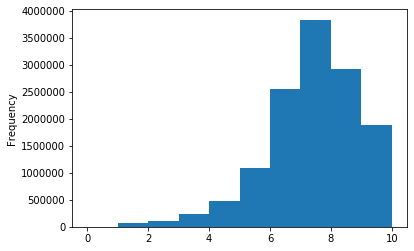

In [5]:
reviews_df['rating'].plot.hist(bins=10)
plt.show()

In [6]:
print(f'Number of unique values of rating = {reviews_df["rating"].nunique()}')
print(f'Some of unique values in rating are = {reviews_df["rating"].unique()}')
reviews_df["rating"]

Number of unique values of rating = 8202
Some of unique values in rating are = [10.       9.999    9.99    ...  7.8524   4.417    7.98525]


0           10.0
1           10.0
2           10.0
3           10.0
4           10.0
            ... 
13170068     3.0
13170069     3.0
13170070     2.5
13170071     2.0
13170072     2.0
Name: rating, Length: 13170073, dtype: float64

## Data Pre-processing

### convert all these rating to integer rating between 0 to 10(inclusive)
### as all rating are in float we can use round()

In [7]:
reviews_df["rating"] = reviews_df["rating"].round()
print(f'Number of unique values of rating = {reviews_df["rating"].nunique()}')

Number of unique values of rating = 11


### Our goal is given the review, predict the rating. Columns other than rating and comments and records without comments are not useful for me. we don't have any good use for this data.
#### Dropping all unused columns.

In [8]:
reviews_df = reviews_df.drop(['Unnamed: 0', 'user', 'ID','name'], axis=1)

#### checking for Null values in rating and comment columns.

In [9]:
reviews_df.isnull().sum()

rating            0
comment    10532317
dtype: int64

#### There are 10,532,317 records without any comments but My goal is given the review, to predict the rating. records without comments are not useful for me. we don't have any good use for this data so I will be deleting these records.

In [10]:
reviews_df.dropna(subset=['comment'])

,rating,comment
2,10.0,"Currently, this sits on my list as my favorite..."
3,10.0,"I know it says how many plays, but many, many ..."
7,10.0,i will never tire of this game.. Awesome
11,10.0,This is probably the best game I ever played. ...
16,10.0,Fantastic game. Got me hooked on games all ove...
...,...,...
13170066,3.0,Horrible party game. I'm dumping this one!
13170067,3.0,Difficult to build anything at all with the in...
13170069,3.0,"Lego created a version of Pictionary, only you..."
13170070,2.0,This game is very similar to Creationary. It c...


#### checking how deleting records with null value is affecting our data distribution.

Text(0, 0.5, 'number of retings')

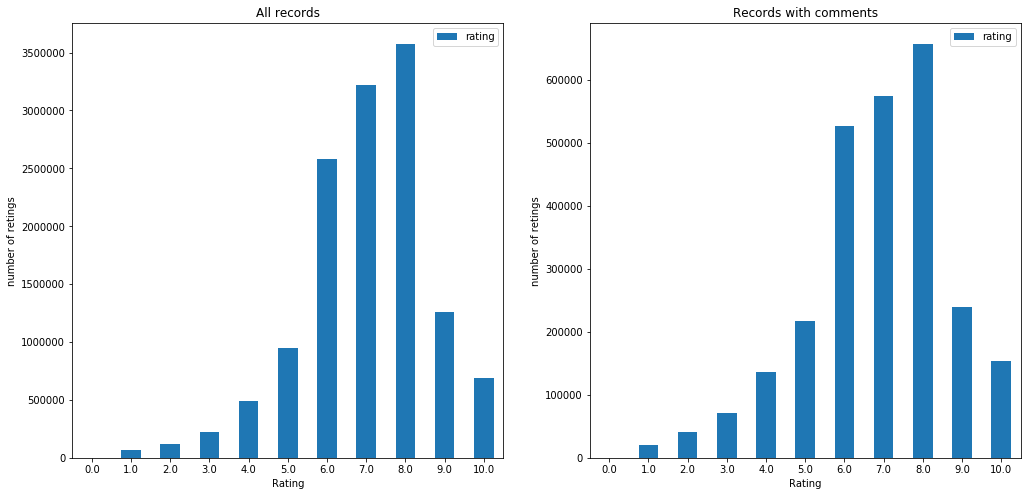

In [11]:
fig, axes = plt.subplots(ncols=2)

plot1 = reviews_df.rating.value_counts().sort_index().plot(kind='bar', legend=True, rot=0, ax=axes[0])
plot1.set_title("All records")
plot1.set_xlabel("Rating")
plot1.set_ylabel("number of retings")
plot2 = reviews_df.dropna(subset=['comment']).rating.value_counts().sort_index().plot(kind='bar', legend=True, rot=0,figsize=(17, 8))
plot2.set_title("Records with comments")
plot2.set_xlabel("Rating")
plot2.set_ylabel("number of retings")


#### data distribution after removing all records with no comment looks same as before.

In [12]:
reviews_df = reviews_df.dropna(subset=['comment'])

#### checking for any duplicate values.

In [13]:
print(f'Number of duplicates in the data = {reviews_df.duplicated().sum()}')

Number of duplicates in the data = 159586


#### Deleting these duplicates as these will cause bias in our model.

In [14]:
reviews_df = reviews_df.drop_duplicates(subset=None, keep='first')
reviews_df

,rating,comment
2,10.0,"Currently, this sits on my list as my favorite..."
3,10.0,"I know it says how many plays, but many, many ..."
7,10.0,i will never tire of this game.. Awesome
11,10.0,This is probably the best game I ever played. ...
16,10.0,Fantastic game. Got me hooked on games all ove...
...,...,...
13170066,3.0,Horrible party game. I'm dumping this one!
13170067,3.0,Difficult to build anything at all with the in...
13170069,3.0,"Lego created a version of Pictionary, only you..."
13170070,2.0,This game is very similar to Creationary. It c...


## Cleaning up comments.

In [15]:
# Removing all 
reviews_df['comment'] = [comment.strip().lower() for comment in reviews_df['comment']]

In [16]:
# removes all other charectores except a-z, A-Z, numbers, _, +, -, /, ', . and white space
reviews_df['comment'] = reviews_df['comment'].replace(r"[^a-zA-Z\d\_\+\-\'\.\/\s]+", ' ', regex = True)

# removes '.' used as period and "'" used as cotation
reviews_df['comment'] = reviews_df['comment'].replace(["./ ", "' ", " '"], " ", regex = True)

#### I am not removing Stop Words as this list contains is, isn't, would, wouldn't 
#### as removing this may impact negatively on our model

In [18]:
reviews_df.head(100)

,rating,comment
2,10.0,currently this sits on my list as my favorite...
3,10.0,i know it says how many plays but many many ...
7,10.0,i will never tire of this game.. awesome
11,10.0,this is probably the best game i ever played. ...
16,10.0,fantastic game. got me hooked on games all ove...
...,...,...
203,10.0,wooden figures edition + catan - exp pre-2007...
205,10.0,imo the perfect game. as well as enjoying this...
207,10.0,this is an outstanding game. simple and effici...
208,10.0,such a simple game but yet you have so many de...


#### Checking for all blank comments introduced after clean up.

In [20]:
len(reviews_df[reviews_df['comment'].apply(lambda x: len(x) == 0)])

63

In [21]:
# Removing these blank comments

In [22]:
reviews_df = reviews_df[reviews_df['comment'] != '']

In [23]:
reviews_df

,rating,comment
2,10.0,currently this sits on my list as my favorite...
3,10.0,i know it says how many plays but many many ...
7,10.0,i will never tire of this game.. awesome
11,10.0,this is probably the best game i ever played. ...
16,10.0,fantastic game. got me hooked on games all ove...
...,...,...
13170066,3.0,horrible party game. i'm dumping this one
13170067,3.0,difficult to build anything at all with the in...
13170069,3.0,lego created a version of pictionary only you...
13170070,2.0,this game is very similar to creationary. it c...


In [24]:
#df = reviews_df.sample(100000)
df = reviews_df

# Building Classification models. 
### we know for text analysis Naive bayes, SVM, are good and KNN is not that good.

### We will divide data into Train set, Dev set and Test set. We will train the classifier with train set then evaluate it with dev set and retrain to get best value for parameters of the model we test this refined model with test data.

#### We are dividing our dataframe to train dataframe, dev dataframe and test data frame.

In [26]:
df, test_df = train_test_split(df, test_size=0.20)

In [27]:
train_df, dev_df = train_test_split(df, test_size=0.20)

Text(0.5, 0, 'Rating')

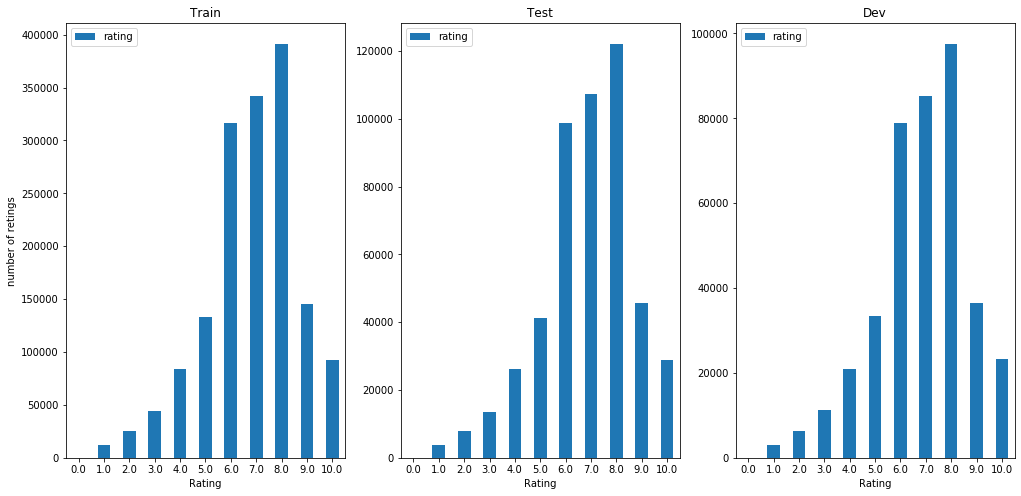

In [28]:
fig, axes = plt.subplots(ncols=3)

plot1 = train_df.rating.value_counts().sort_index().plot(kind='bar', legend=True, rot=0, ax=axes[0])
plot1.set_title("Train")
plot1.set_xlabel("Rating")
plot1.set_ylabel("number of retings")
plot2 = test_df.rating.value_counts().sort_index().plot(kind='bar', legend=True, rot=0, ax=axes[1])
plot2.set_title("Test")
plot2.set_xlabel("Rating")
plot3 = dev_df.rating.value_counts().sort_index().plot(kind='bar', legend=True, rot=0,figsize=(17, 8))
plot3.set_title("Dev")
plot3.set_xlabel("Rating")

### To train any model we need to convert text to TF IDF form 
#### The formula that is used to compute the tf-idf for a term t of a document d in a document set is 
#### tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as idf(d, t) = log [ (1 + n) / (1 + df(d, t)) ] + 1. where n is the total number of documents in the document set and df(t) is the document frequency of t; the document frequency is the number of documents in the document set that contain the term t. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set

#### We take only Train data set to calculate n.

In [29]:
# we are selecting top 1000 words droping other low friquency words

tfidf = TfidfVectorizer(max_features=1000)

# transforming traing data to tfidf form arrays. we can use this to train any model
x_train = tfidf.fit_transform(train_df['comment']).toarray()
y_train = np.asarray(train_df['rating'])

In [30]:
x_dev = tfidf.transform(dev_df['comment']).toarray()
y_dev = np.asarray(dev_df['rating'])

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_dev.shape)
print(y_dev.shape)

(1585988, 1000)
(1585988,)
(396497, 1000)
(396497,)


#### First we will try with the Naive Bayes model. As this is text analysis and our vector contains values between 0 to 1 not just binary values we will use Multinomial Naive Bayes (MNB).

In [32]:
mnb = MultinomialNB(alpha=1)
mnb.fit(x_train, y_train)
y_dev_pred_mnb = mnb.predict(x_dev)

# Calculate the Mean Squared Error and Accuracy
mse_mnb = mean_squared_error(y_dev, y_dev_pred_mnb)
accuracy_mnb = accuracy_score(y_dev, y_dev_pred_mnb)*100

# Print the Mean Squared Error and Accuracy
print(f'Mean Squared Error = {mse_mnb}')
print(f'Accuracy = {accuracy_mnb}')

Mean Squared Error = 3.047339576339796
Accuracy = 30.555590584544145


In [33]:
# Train and Predict the data using Multinomial Naive Bayes with below alpha values.
alpha = [0.01, .1, 0.5, 1, 2]
mnb = {}
mse_mnb = {}
accuracy_mnb = {}
y_dev_pred_mnb = {}
for a in alpha:
    mnb[a] = MultinomialNB(alpha=a)
    mnb[a].fit(x_train, y_train)
    
    y_dev_pred_mnb[a] = (mnb[a].predict(x_dev))

    # Calculate the Mean Squared Error and Accuracy
    mse_mnb[a] = mean_squared_error(y_dev, y_dev_pred_mnb[a])
    accuracy_mnb[a] = accuracy_score(y_dev, y_dev_pred_mnb[a])*100

    # Print the Mean Squared Error and Accuracy
    print(f'Mean Squared Error = {mse_mnb[a]} for alpha = {a}')
    print(f'Accuracy = {accuracy_mnb[a]} for alpha = {a}')

Mean Squared Error = 3.0467973275964257 for alpha = 0.01
Accuracy = 30.55962592402969 for alpha = 0.01
Mean Squared Error = 3.0469360423912413 for alpha = 0.1
Accuracy = 30.559878132747535 for alpha = 0.1
Mean Squared Error = 3.0471151105809122 for alpha = 0.5
Accuracy = 30.557608254286915 for alpha = 0.5
Mean Squared Error = 3.047339576339796 for alpha = 1
Accuracy = 30.555590584544145 for alpha = 1
Mean Squared Error = 3.0479499214369845 for alpha = 2
Accuracy = 30.555338375826295 for alpha = 2


### We got the best MSE for alpha =.05 but we got best accuracy for alpha = .1, which one to choose is based on our requirement. Here we will chose alpha = .1 

In [34]:
# Storing MSE and Accuracy for future comparison
mse = {}
accuracy = {}
model = {}
model["MNB"] = mnb
mse["MNB"] = mse_mnb
accuracy["MNB"] = accuracy_mnb

## We will try Support Vector Machines (SVMs)

In [35]:
C = [0.01, 0.1, 1, 10, 100]
svm = {}
mse_svm = {}
accuracy_svm = {}
y_dev_pred_svm = {}
for c in C:
    svm[c] = LinearSVC(C=c, dual = False)
    svm[c].fit(x_train, y_train)
    
    y_dev_pred_svm[c] = (svm[c].predict(x_dev))

    # Calculate the Mean Squared Error and Accuracy
    mse_svm[c] = mean_squared_error(y_dev, y_dev_pred_svm[c])
    accuracy_svm[c] = accuracy_score(y_dev, y_dev_pred_svm[c])*100

    # Print the Mean Squared Error and Accuracy
    print(f'Mean Squared Error = {mse_svm[c]} for C = {c}')
    print(f'Accuracy = {accuracy_svm[c]} for C = {c}')

Mean Squared Error = 2.881683846283831 for C = 0.01
Accuracy = 31.76871451738601 for C = 0.01
Mean Squared Error = 2.8787506588952754 for C = 0.1
Accuracy = 31.80074502455252 for C = 0.1
Mean Squared Error = 2.8786548195824935 for C = 1
Accuracy = 31.806545825062987 for C = 1
Mean Squared Error = 2.878314337813401 for C = 10
Accuracy = 31.804780364038066 for C = 10
Mean Squared Error = 2.8786447312337797 for C = 100
Accuracy = 31.80578919890945 for C = 100


### Here we got the best MSE and best accuracy for C = 1, so we can directly choose C = 1. but the difference in accuracy is very less. Also SVM looks better than Naive Bayes

In [36]:
# seving model information to use for ensemble models. 
model['SVM'] = svm
mse['SVM'] = mse_svm
accuracy['SVM'] = accuracy_svm

#### Let us create an Ensemble model using these 10 models we have from MNB and SVM. I am directly using what I learnt from class here. I have not seen anyone use Ensemble model like this. Here I am running data with all models  I am selecting the most common value. I am also trying to give weightage based on accuracy of the model.

In [42]:
def ensemble(x):
    x_array = tfidf.transform(x).toarray()
    y_pred_dict = {}
    for a in alpha:
        y_pred = model['MNB'][a].predict(x_array)[0]
        if y_pred in y_pred_dict:
            y_pred_dict[y_pred] += (accuracy['MNB'][a])
        else:
            y_pred_dict[y_pred] = (accuracy['MNB'][a])
            
    for c in C:
        y_pred = model['SVM'][c].predict(x_array)[0]
        if y_pred in y_pred_dict:
            y_pred_dict[y_pred] += (accuracy['SVM'][c])
        else:
            y_pred_dict[y_pred] = (accuracy['SVM'][c])
        
    inverse = [(value, key) for key, value in y_pred_dict.items()]
    return max(inverse)[1]

In [45]:
y_dev_pred_ens = []

for index, row in dev_df.iterrows():
    y_dev_pred_ens.append(ensemble([row['comment']]))
    

# Calculate the Mean Squared Error and Accuracy
mse_ens = mean_squared_error(y_dev, y_dev_pred_ens)
accuracy_ens = accuracy_score(y_dev, y_dev_pred_ens)*100

# Print the Mean Squared Error and Accuracy
print(f'Mean Squared Error = {mse_ens}')
print(f'Accuracy = {accuracy_ens}')
    

Mean Squared Error = 2.8813357982532026
Accuracy = 31.76190488200415


### Accuracy is same as some of SVM models, not increased as expected because for ensamble to work, models should be independent of each other, accuracy of each model should be greater than the random chance, and there should be more then two models. our models are not independent as we are using almost the same models with only created using difference in parameter.

### Let us try the Random forest classifier. Random forest uses Decision trees with ensembles.

In [37]:
estimators = [1, 10, 50]
rfc = {}
mse_rfc = {}
accuracy_rfc = {}
y_dev_pred_rfc = {}
for n in estimators:
    rfc[n] = RandomForestClassifier(max_depth=25, n_estimators=n)
    rfc[n].fit(x_train, y_train)
    
    y_dev_pred_rfc[n] = (rfc[n].predict(x_dev))

    # Calculate the Mean Squared Error and Accuracy
    mse_rfc[n] = mean_squared_error(y_dev, y_dev_pred_rfc[n])
    accuracy_rfc[n] = accuracy_score(y_dev, y_dev_pred_rfc[n])*100

    # Print the Mean Squared Error and Accuracy
    print(f'Mean Squared Error = {mse_rfc[n]} for n = {n}')
    print(f'Accuracy = {accuracy_rfc[n]} for n = {n}')

Mean Squared Error = 3.8618173655790584 for C = 1
Accuracy = 26.693518488160063 for C = 1
Mean Squared Error = 3.432066320804445 for C = 10
Accuracy = 28.87537610625049 for C = 10
Mean Squared Error = 3.3534932168465335 for C = 50
Accuracy = 29.78685841254789 for C = 50


In [38]:
# Saving models
model['RFC'] = rfc
mse['RFC'] = mse_rfc
accuracy['RFC'] = accuracy_rfc

#### Random Forest Classifier Accuracy is very less then other two models, but this is bit different model then other models so lets try this with other models in ensemble.

In [47]:
def ensemble1(x):
    x_array = tfidf.transform(x).toarray()
    y_pred_dict = {}
    for a in alpha:
        y_pred = model['MNB'][a].predict(x_array)[0]
        if y_pred in y_pred_dict:
            y_pred_dict[y_pred] += (accuracy['MNB'][a])
        else:
            y_pred_dict[y_pred] = (accuracy['MNB'][a])
            
    for c in C:
        y_pred = model['SVM'][c].predict(x_array)[0]
        if y_pred in y_pred_dict:
            y_pred_dict[y_pred] += (accuracy['SVM'][c])
        else:
            y_pred_dict[y_pred] = (accuracy['SVM'][c])
            
    for n in estimators:
        y_pred = model['ENS'][n].predict(x_array)[0]
        if y_pred in y_pred_dict:
            y_pred_dict[y_pred] += (accuracy['ENS'][n])
        else:
            y_pred_dict[y_pred] = (accuracy['ENS'][n])
        
    inverse = [(value, key) for key, value in y_pred_dict.items()]
    return max(inverse)[1]

In [48]:
y_dev_pred_ens1 = []
for index, row in dev_df.iterrows():
    y_dev_pred_ens1.append(ensemble1([row['comment']]))

y_dev = np.asarray(dev_df['rating'])
# Calculate the Mean Squared Error and Accuracy
mse_ens = mean_squared_error(y_dev, y_dev_pred_ens1)
accuracy_ens = accuracy_score(y_dev, y_dev_pred_ens1)*100

# Print the Mean Squared Error and Accuracy
print(f'Mean Squared Error = {mse_ens}')
print(f'Accuracy = {accuracy_ens}')
    

Mean Squared Error = 2.9767261795171214
Accuracy = 31.20729791145961


#### We don't see any increase in accuracy, this may still be due to models being not independent and low accuracy of Random Forest Classifier.

#### We don't see any accuracy in the above method so lets create different MNB and SVM models using the bagging method. Here I am not using traditional bagging as we have a lot of data I am sampling 20000 records from the main dataset using it for training and evaluation. 

In [54]:
smpl_model = []
smpl_accuracy = []
smpl_mse = []
for i in range(5):
    smpl_df = reviews_df.sample(20000)
    smpl_tfidf = TfidfVectorizer(max_features=200)
    
    smpl_train_df, smpl_dev_df = train_test_split(smpl_df, test_size=0.20)

    # transforming traing data to smpl_tfidf form arrays. we can use this to train any model
    x_smpl_train = smpl_tfidf.fit_transform(smpl_train_df['comment']).toarray()
    y_smpl_train = np.asarray(smpl_train_df['rating'])
    
    x_smpl_dev = smpl_tfidf.transform(smpl_dev_df['comment']).toarray()
    y_smpl_dev = np.asarray(smpl_dev_df['rating'])
    
    smpl_mnb = MultinomialNB(alpha=.1)
    smpl_mnb.fit(x_smpl_train, y_smpl_train)
    y_dev_pred_smpl_mnb = smpl_mnb.predict(x_smpl_dev)

    # Calculate the Mean Squared Error and Accuracy
    mse_smpl_mnb = mean_squared_error(y_smpl_dev, y_dev_pred_smpl_mnb)
    accuracy_smpl_mnb = accuracy_score(y_smpl_dev, y_dev_pred_smpl_mnb)*100

    # Print the Mean Squared Error and Accuracy
    print(f'Mean Squared Error of MNB = {mse_smpl_mnb}')
    print(f'Accuracy of MNB = {accuracy_smpl_mnb}')
    
    smpl_svm = LinearSVC(C=1, dual = False)
    smpl_svm.fit(x_smpl_train, y_smpl_train)
    
    y_dev_pred_smpl_svm = (smpl_svm.predict(x_smpl_dev))

    # Calculate the Mean Squared Error and Accuracy
    mse_smpl_svm = mean_squared_error(y_smpl_dev, y_dev_pred_smpl_svm)
    accuracy_smpl_svm = accuracy_score(y_smpl_dev, y_dev_pred_smpl_svm)*100

    # Print the Mean Squared Error and Accuracy
    print(f'Mean Squared Error of SVM = {mse_smpl_svm}')
    print(f'Accuracy of SVM = {accuracy_smpl_svm}')
    
    smpl_model.append(smpl_mnb)
    smpl_model.append(smpl_svm)
    smpl_accuracy.append(accuracy_smpl_mnb)
    smpl_accuracy.append(accuracy_smpl_svm)
    smpl_mse.append(mse_smpl_mnb)
    smpl_mse.append(mse_smpl_svm)
    

Mean Squared Error of MNB = 3.5055
Accuracy of MNB = 27.500000000000004
Mean Squared Error of SVM = 3.31425
Accuracy of SVM = 27.700000000000003
Mean Squared Error of MNB = 3.72425
Accuracy of MNB = 27.750000000000004
Mean Squared Error of SVM = 3.4325
Accuracy of SVM = 28.15
Mean Squared Error of MNB = 3.59625
Accuracy of MNB = 27.175
Mean Squared Error of SVM = 3.343
Accuracy of SVM = 27.224999999999998
Mean Squared Error of MNB = 3.6135
Accuracy of MNB = 27.825
Mean Squared Error of SVM = 3.45025
Accuracy of SVM = 27.575
Mean Squared Error of MNB = 3.687
Accuracy of MNB = 28.1
Mean Squared Error of SVM = 3.3765
Accuracy of SVM = 27.85


### Accuracy is not that good but let us try ensemble methods using these models.

In [57]:
def ensemble2(x):
    x_smpl_array = smpl_tfidf.transform(x).toarray()
    y_smpl_pred_dict = {}
    for i in range(10):
        y_pred = smpl_model[i].predict(x_smpl_array)[0]
        if y_pred in y_smpl_pred_dict:
            y_smpl_pred_dict[y_pred] += (smpl_accuracy[i])
        else:
            y_smpl_pred_dict[y_pred] = (smpl_accuracy[i])
        
    inverse = [(value, key) for key, value in y_smpl_pred_dict.items()]
    return max(inverse)[1]

In [58]:
y_dev_pred_ens2 = []
for index, row in dev_df.iterrows():
    y_dev_pred_ens2.append(ensemble2([row['comment']]))

y_dev = np.asarray(dev_df['rating'])
# Calculate the Mean Squared Error and Accuracy
mse_ens = mean_squared_error(y_dev, y_dev_pred_ens2)
accuracy_ens = accuracy_score(y_dev, y_dev_pred_ens2)*100

# Print the Mean Squared Error and Accuracy
print(f'Mean Squared Error = {mse_ens}')
print(f'Accuracy = {accuracy_ens}')
    

Mean Squared Error = 3.588660191628184
Accuracy = 27.74926418106568


### We don't find any increase in accuracy by this ensemble.This maybe due to low accuracy of each model, and also looks mainly due to dependency of each model we are using. 

## Conclusion    
#### We have tried Multinomial Naive Bayse, SVM, Random forest classifier. and ensembles with these classifiers and ensembles with data bagging. Here SVM gave the best accuracy, ensemble model should have done better but as we are using almost the same(dependent) models with less accuracy, ensemble model didn't do as expected. So I will take the SVM model with alpha 1 for my model testing.

## Testing
#### We will use test data on our best model - SVM with C = 1 to test this program.

In [59]:
x_test = tfidf.transform(test_df['comment']).toarray()
y_test = np.asarray(test_df['rating'])

In [61]:
c=1
y_test_pred = (svm[c].predict(x_test))

# Calculate the Mean Squared Error and Accuracy
mse_test = mean_squared_error(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)*100

# Print the Mean Squared Error and Accuracy
print(f'Mean Squared Error test = {mse_test}')
print(f'Accuracy test = {accuracy_test}')


Mean Squared Error test = 2.8612087437603657
Accuracy test = 31.863597661120775


In [51]:
x = input('Enter your comment :')
print(ensemble([x]))

Enter your comment :worst game ever
1.0


###### Take backup of model and tfidf
Reference: https://medium.com/datadriveninvestor/deploy-your-machine-learning-model-using-flask-made-easy-now-635d2f12c50c  

In [43]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
pickle.dump(accuracy, open('accuracy.pkl', 'wb'))

In [44]:
pickle.dump(svm[1], open('svm1.pkl', 'wb'))